## Tarea 7 del curso CM-072

* Nombre y apellidos: Nelson Steven Sanabio Maldonado
* Fecha de presentación: 17 de octubre.



LendingClub es una compañía de préstamos *peer-to-peer* que conecta directamente a los prestatarios con potenciales prestamistas/inversionistas.

Construirás un modelo de clasificación para predecir si un préstamo realizado a través del LendingClub tiene probabilidad de no ser pagado.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
# Cargar la data
loans = pd.read_csv("lending-club-data.csv", low_memory=False)
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


1 . Carga en una variable de nombre `todo_columnas` el nombre de todas las columnas del conjunto de datos.

In [2]:
# Almacenando los nombres de las columnas en la variable "todo_columnas"
todo_columnas = loans.columns.values.tolist()
print("Las columnas son :\n",todo_columnas)

Las columnas son :
 ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans', 'emp_length_num', 'grade_num', 'sub_grade_num', 'delinq_2yrs_zero', 'pub_rec_zero', 'collections_12_mths_zero', 'sho

2 . La columna que contiene la información que queremos predecir se llama `malos_prestamos`. En esta columna, el valor 1 significa un préstamo riesgoso (malo), mientras que 0 significa un préstamos seguro.

Para hacer el trabajo más intuitivo, crea una nueva columna `prestamos_seguros` con el siguiente valor:

* +1 si es un préstamo seguro
* -1 si es un préstamos riesgoso (malo)

In [3]:
# Los 'malos_prestamos' equivale al nombre "bad_loans"
prestamos_seguros = 1-2*loans["bad_loans"]
loans=loans.drop(['bad_loans'],axis=1)
loans=pd.concat([loans,prestamos_seguros],axis=1)
loans.rename(columns = {'bad_loans':'prestamos_seguros'}, inplace=True)
loans['prestamos_seguros'].head()

0    1
1   -1
2    1
3    1
4    1
Name: prestamos_seguros, dtype: int64

3 . Calcula la distribución en porcentaje de préstamos malos y préstamos buenos (debe sumar 100%).

In [4]:
prestamos_total = pd.notnull(loans.prestamos_seguros).values.sum()

prestamos_malos = loans.loc[loans['prestamos_seguros']==-1]

prestamos_buenos=loans.loc[loans['prestamos_seguros']==1]

prestamos_malos_porcentaje = (loans['prestamos_seguros']==-1).sum()/prestamos_total 
prestamos_buenos_porcentaje = 1-prestamos_malos_porcentaje

print("Porcentajes : \n Prestamos malos:\t{} \t {}\n Prestamos Buenos : \t{} \t {}".format(len(prestamos_malos),prestamos_malos_porcentaje,len(prestamos_buenos),prestamos_buenos_porcentaje))

Porcentajes : 
 Prestamos malos:	23150 	 0.18881466800427382
 Prestamos Buenos : 	99457 	 0.8111853319957262


4 . Una manera de abordar conjuntos de datos desbalanceados es con un submuestreo  de la clase más grande hasta que la distribución de clases sea mitad y mitad. Vamos a realizar un submuestreo de los préstamos buenos para balancear nuestro conjunto de datos. Ello significa que vamos a descartar muchas observaciones. 

* Pon en una variable `prestamos_arriesgado` todos y solo los préstamos malos.
* Pon en una variable `prestamos_seguros` una muestra aleatoria de préstamos buenos **del mismo tamaño** que la cantidad de préstamos malos. (Usa [pandas.DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html) con el atributo `random_state=0`)
* Junta en una nueva variable `prestamos_balanceados`, los dos grupos anteriores: `prestamos_arriesgados` y `prestamos_seguros`.

In [5]:
prestamos_arriesgado=pd.DataFrame(prestamos_malos)
# random_state, sirve para fijar un estado aleatorio de datos con un valor igual 0
prestamos_seguros=prestamos_buenos.sample(len(prestamos_malos),random_state=0)

prestamos_balanceados=pd.concat([prestamos_seguros,prestamos_arriesgado],sort=False)

In [6]:
print(prestamos_balanceados.shape)
# Se visualiza que la mitad de la columna prestamos_seguros son 1's y la otra son -1's
prestamos_balanceados['prestamos_seguros'].value_counts()
# A este ultimo se le llama datos Balanceados

(46300, 68)


-1    23150
 1    23150
Name: prestamos_seguros, dtype: int64

5 . Asigna a una variable `subconjunto_prestamos` sólo el siguiente subconjunto de características que son las que usaremos:

```python
caracteristica = ['grade',               # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]
```

Asimismo, asigna a una variable **`y`** los valores de la columna `prestamos_seguros`.

In [7]:
subconjunto_prestamos = prestamos_balanceados[['grade','sub_grade','short_emp','emp_length_num','home_ownership','dti','purpose','term','last_delinq_none','last_major_derog_none','revol_util','total_rec_late_fee']]
y = prestamos_balanceados[['prestamos_seguros']]

6 .  Usando [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) convierte las variables categóricas de `subconjunto_prestamos` en variables numéricas *one-hot*. Guarda el nuevo conjunto de datos en `X`.

In [8]:
# Una función para convertir una columna en especial a númerico.
def createDummies(df,var_name):
    dummy = pd.get_dummies(df[var_name],prefix=var_name)
    df = df.drop(var_name,axis=1)
    df = pd.concat([df,dummy],axis=1)
    return df

# Para poder crear el modelo de clasificación debemos tener todos los datos como númericos.
# Para usar la data de subconjunto_prestamos debemos convertir de datos categoricos a datos númericas.

X = pd.get_dummies(subconjunto_prestamos)
X.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,grade_A,grade_B,grade_C,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
81182,0,3,20.69,0,1,94.2,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
62492,0,11,17.97,1,1,51.7,0.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
65470,0,11,23.77,0,1,57.4,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9259,0,11,17.01,1,1,69.7,0.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
77387,0,8,19.83,1,1,91.8,0.0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


7 .  Empleando `sklearn.model_selection.train_test_split` separa el conjunto de datos en un 90% para entrenamiento y validación (`X_entrenamiento_val`, `y_entrenamiento_val`), y 10% para pruebas (`X_prueba`, `y_prueba`).

Luego separa (`X_entrenamiento_val`, `y_entrenamiento_val`) en un 80% para entrenamiento (`X_entrenamiento`, `y_entrenamiento`) y 20% para validación (`X_val`, `y_val`).

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import recall_score,confusion_matrix,classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import itertools


X_entrenamiento_val, X_prueba, y_entrenamiento_val, y_prueba = train_test_split(X,y,test_size=0.10,random_state=90)
X_entrenamiento_val.shape

(41670, 67)

In [10]:
X_entrenamiento, X_val, y_entrenamiento, y_val = train_test_split(X_entrenamiento_val,y_entrenamiento_val,test_size=0.20,random_state=80)
X_entrenamiento.shape

(33336, 67)

8 . Entrena un modelo como Regresión Logística, Naive Bayes, KNN y un cuarto modelo de tu elección, con las siguientes indicaciones:

* Utilizar el uso apropiado de la normalización (Scaling) de datos si fuese necesario.
* El uso apropiado de una técnica para la selección de los mejores parámetros de cada modelo (p.ej. búsqueda grid o búsqueda aleatoria)
* Reporte para cada modelo la exactitud , precisión y exhaustividad, F1-Score  **en el conjunto de pruebas.** y muestra la matriz de confusión.
* Comenta tus resultados.

#### Antes de empezar usaré un algoritmo que muestra gráficamente los resultados de la matriz de confusión, normalizado

In [11]:
class_names = y.columns.values.tolist()
clase = y.columns
# Dejo el link sobre plot de la matriz de confusión  : 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,normalize=True,title='Matriz de Confusión',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta de Predicción')
    plt.tight_layout()

##### Creamos una función donde nos muestra la exactitud , precisión y exhaustividad, F1-Score en el conjunto de pruebas y muestra la matriz de confusión

In [12]:
def Resultados(predicciones_test,y_test,verbose=False):
    tn, fp, fn, tp=confusion_matrix(y_val, predicciones_test).ravel()
    if verbose:
        print ('              +-----------------------+')
        print ('              |      Predicción       |')
        print ('              +-----------------------+')
        print ('              |      -     |     +    |')
        print ('+-------+-----+------------+----------+')
        print ('| Valor |  -  |    %d    |   %d   |'   % (tn, fp) )
        print ('| real  +-----+------------+----------+')
        print ('|       |  +  |    %d     |   %d   |'    % (fn, tp) )
        print ('+-------+-----+------------+----------+')
        print ()
        
        print(classification_report(y_val, predicciones_test))
        print("Exactitud : %.2f"%((tp+tn)/(tp+tn+fp+fn))) 
        
        plt.figure()
        plot_confusion_matrix(confusion_matrix(y_val,predicciones_test), classes=class_names,normalize=True)
        plt.show()

### Regresión Logística

              +-----------------------+
              |      Predicción       |
              +-----------------------+
              |      -     |     +    |
+-------+-----+------------+----------+
| Valor |  -  |    2704    |   1487   |
| real  +-----+------------+----------+
|       |  +  |    1434     |   2709   |
+-------+-----+------------+----------+

             precision    recall  f1-score   support

         -1       0.65      0.65      0.65      4191
          1       0.65      0.65      0.65      4143

avg / total       0.65      0.65      0.65      8334

Exactitud : 0.65
Matriz de Confusión Normalizada
[[0.64519208 0.35480792]
 [0.346126   0.653874  ]]


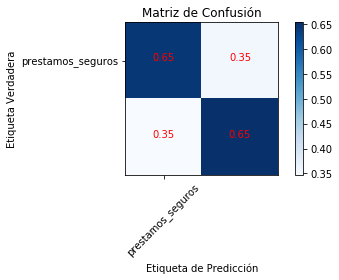

In [13]:
Regresion_Logistica = LogisticRegression(random_state=0).fit(X_entrenamiento, y_entrenamiento.values.ravel())
predicciones_test = Regresion_Logistica.predict(X_val)
Resultados(predicciones_test,y_val,verbose=True)
tn, fp, fn, tp=confusion_matrix(y_val, predicciones_test).ravel()

Sabemos que el modelo de Regresión Logistica se usa cuando las salidas son discretas (y no continuas), es un modelo de aprendizaje Supervisado, vemos que los datos están parejos es decir que la exactitud es igual al recall y a la especifidad y tambien a f1-score. Además los tp y tn se tienen mayores datos y esto lo vuelve mas aún un modelo mas optimo.

### Naive Bayes

              +-----------------------+
              |      Predicción       |
              +-----------------------+
              |      -     |     +    |
+-------+-----+------------+----------+
| Valor |  -  |    1783    |   2408   |
| real  +-----+------------+----------+
|       |  +  |    844     |   3299   |
+-------+-----+------------+----------+

             precision    recall  f1-score   support

         -1       0.68      0.43      0.52      4191
          1       0.58      0.80      0.67      4143

avg / total       0.63      0.61      0.60      8334

Exactitud : 0.61
Matriz de Confusión Normalizada
[[0.42543546 0.57456454]
 [0.20371711 0.79628289]]


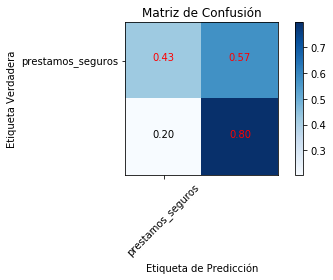

In [14]:
Naive_Bayes= GaussianNB(priors=None).fit(X_entrenamiento, y_entrenamiento.values.ravel())
predicciones_test=Naive_Bayes.predict(X_val)
Resultados(predicciones_test,y_val,verbose=True)
tn, fp, fn, tp=confusion_matrix(y_val, predicciones_test).ravel()

Sabemos que el modelo de Naives Bayes utiliza el teorema de Bayes de independencia condicional entre cada par de caracteristicas, es un modelo de aprendizaje Supervisado, vemos que la exáctitud es menor que el anterior modelo, además decimos que los fp son mayores que los tn esto a grandes rasgos nos perjudica en la predicción. No sería un modelo para este conjunto de datos.

### K-Nearest-Neighbors

              +-----------------------+
              |      Predicción       |
              +-----------------------+
              |      -     |     +    |
+-------+-----+------------+----------+
| Valor |  -  |    2400    |   1791   |
| real  +-----+------------+----------+
|       |  +  |    1485     |   2658   |
+-------+-----+------------+----------+

             precision    recall  f1-score   support

         -1       0.62      0.57      0.59      4191
          1       0.60      0.64      0.62      4143

avg / total       0.61      0.61      0.61      8334

Exactitud : 0.61
Matriz de Confusión Normalizada
[[0.57265569 0.42734431]
 [0.35843592 0.64156408]]


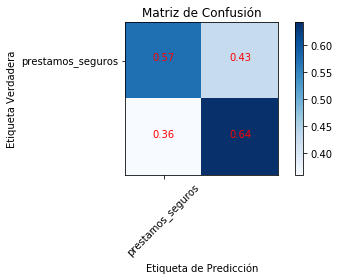

In [15]:
NNK = KNeighborsClassifier(n_neighbors=50, algorithm='auto')
NNK.fit(X_entrenamiento,y_entrenamiento.values.ravel())
predicciones_test=NNK.predict(X_val)
Resultados(predicciones_test,y_val,verbose=True)
tn, fp, fn, tp=confusion_matrix(y_val, predicciones_test).ravel()

Se sabe que KNN sirve para modelos de predicciones y clasificación, en este caso lo usaremos para clasificación por lo cual entrenando el modelo y con un K que viene hacer el umbral, se obtuvo que su exáctitud es de 0.61 igual que el modelo anterior. Este modelo tiene similiarmente los resultados del modelo de Regresión Logistica, comparando los modelos, vemos que los tp y tn son menores que el modelo RL, además esto lo hace menos optimo y tiene menor exactitud y especificidad. Por lo cual no sería un modelo para este conjunto de datos.

### Support Vector Machine

In [16]:
from sklearn.linear_model import Perceptron
percentron = Perceptron(tol=1e-3, random_state=0)
percentron.fit(X_entrenamiento, y_entrenamiento.values.ravel())

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [17]:
predicciones_test = percentron.predict(X_val)

              +-----------------------+
              |      Predicción       |
              +-----------------------+
              |      -     |     +    |
+-------+-----+------------+----------+
| Valor |  -  |    2710    |   1481   |
| real  +-----+------------+----------+
|       |  +  |    1525     |   2618   |
+-------+-----+------------+----------+

             precision    recall  f1-score   support

         -1       0.64      0.65      0.64      4191
          1       0.64      0.63      0.64      4143

avg / total       0.64      0.64      0.64      8334

Exactitud : 0.64
Matriz de Confusión Normalizada
[[0.64662372 0.35337628]
 [0.36809076 0.63190924]]


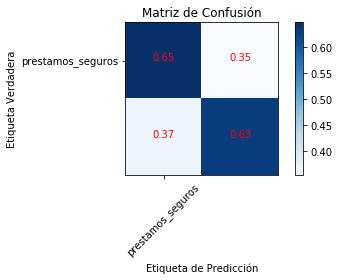

In [18]:
Resultados(predicciones_test,y_val,verbose=True)
tn, fp, fn, tp=confusion_matrix(y_val, predicciones_test).ravel()

Este modelo es un Algoritmo de clasificación adecuado para el aprendizaje a gran escala. Viendo con los demás modelo anteriores vemos de que es casi parecido y esta cerca al modelo de Regresión logística. Varia un poco en los tp y además los datos que pidió calcular son menores que el modelo de Regresión Logística.

## Conclusión

De los modelo se puede decir; que los modelos para este conjunto de datos sería el modelo de Regresión Lineal y Percentrón, aqui vemos que las metricas tienen el mismo valor esto se debe a que el conjunto de datos es balanceado. Pues bien el error entre los modelos mencionados es de 0.01, no es mucha la diferencia es por eso que puede ser elegido cualquiera de los dos modelos, sería cuestión de analizar el sesgo y la varianza junto con los RMSE y tener mucho cuidado con el entrenamiento (overfitting y underfitting), esto influye mucho en la predicción del conjunto de datos.